In [61]:
import numpy as np
import mdtraj as mdt
import MDAnalysis as mda

import matplotlib.pyplot as plt


In [140]:
def get_nearby_residues(holo_xtal, ligand_resn, dist_cutoff):

    #handle bricks
    if ligand_resn == "None":
        print("no valid ligands found")
        return []

    #handle everything else
    if type(ligand_resn) == str: #select single ligands
        ligand_select_str = f"resname '{ligand_resn}'"

    elif len(ligand_resn)>1:     #select multiple ligands
        #assemble query for all ligands listed
        molecule_queries = []
        for lname in ligand_resn:
            molecule_queries.append(f"resname '{lname}'")
        ligand_select_str = " or ".join(molecule_queries)

    else:                        #use hardcoded query
        ligand_select_str = ligand_resn[0]

    #get indices of ligand and protein atoms
    ligand_ai = holo_xtal.top.select(f"({ligand_select_str}) and not element H")
    protein_ai = holo_xtal.top.select("protein and not element H")

    #get indices of ligand-coordinating protein atoms; index 0 indicates the 0th trajectory frame
    lining_ai = mdt.compute_neighbors(holo_xtal, dist_cutoff, ligand_ai, haystack_indices=protein_ai, periodic = False)[0]

    #get residue indices and numbers for the holo structure
    lining_resids = np.unique([holo_xtal.top.atom(i).residue.index for i in lining_ai])    #0-indices of the lining residues in the mdtraj structure
    lining_resseqs = np.unique([holo_xtal.top.atom(i).residue.resSeq for i in lining_ai])  #rcsb pdb residue numbers of the lining residues
    
    #print([f"resid {i}" for i in lining_resids])
    lining_ai_resi = np.unique(holo_xtal.top.select(" or ".join([f"resid {i}" for i in lining_resids])))
    
    lining_ai_byresi = [holo_xtal.top.select(f"resid {i}") for i in lining_resids]
    lining_names_byresi = [str(holo_xtal.top.atom(holo_xtal.top.select(f"resid {i}")[0]).residue) for i in lining_resids]

    return [lining_ai, lining_resids, lining_resseqs, lining_ai_resi, lining_ai_byresi, lining_names_byresi]

In [126]:
#filepaths
trjpath = "/Users/jonathanborowsky/Documents/UCSF/classes/bp219/trj"

ptopapo = f"{trjpath}/DESRES-Trajectory_sarscov2-10875753-no-water-zinc-glueCA/sarscov2-10875753-no-water-zinc-glueCA/apo_top.pdb"
ptopholo = f"{trjpath}/DESRES-Trajectory_sarscov2-10875754-no-water-zinc-glueCA/sarscov2-10875754-no-water-zinc-glueCA/holo_top.pdb"

ptrjapo  = f"{trjpath}/DESRES-Trajectory_sarscov2-10875753-no-water-zinc-glueCA/sarscov2-10875753-no-water-zinc-glueCA/sarscov2-10875753-no-water-zinc-glueCA-0000.dcd"
ptrjholo = f"{trjpath}/DESRES-Trajectory_sarscov2-10875754-no-water-zinc-glueCA/sarscov2-10875754-no-water-zinc-glueCA/sarscov2-10875754-no-water-zinc-glueCA-0000.dcd"


In [127]:
#load trajectories

trjapo = mdt.load_dcd(ptrjapo, top = ptopapo)
trjholo = mdt.load_dcd(ptrjholo, top = ptopholo)

In [141]:
#get ligand-lining residues using the holo topology
#note that this does not account for changes to 
#ligand coordination over the course of the trajectory

dist_cutoff = 0.5 #nanometers
ligand_resn = "XX5"
topholo = mdt.load(ptopholo)

lining_inds = get_nearby_residues(topholo, ligand_resn, dist_cutoff)

#print("+".join([str(i) for i in lining_inds[2]]))

In [131]:
#calculate RMSF of each atom

rmsf_apo = mdt.rmsf(trjapo, reference = None)
rmsf_holo = mdt.rmsf(trjholo, reference = None)

#separate ligand-lining and non-ligand-lining RMSFs

rmsf_apo_noligand = []
rmsf_apo_ligand = rmsf_apo[lining_inds[3]]
rmsf_holo_noligand = []
rmsf_holo_ligand = rmsf_holo[lining_inds[3]]

rmsf_apo_ligand_byres = []
rmsf_holo_ligand_byres = []

for r in lining_inds[4]:
    rmsf_apo_ligand_byres.append(np.mean(rmsf_apo[r]))
    rmsf_holo_ligand_byres.append(np.mean(rmsf_holo[r]))


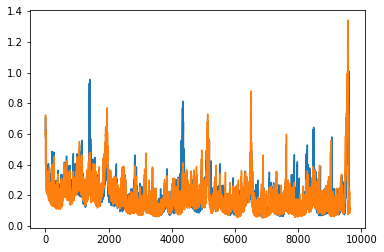

In [132]:
#plot overall atom-level results

plt.plot(rmsf_apo)
plt.plot(rmsf_holo)

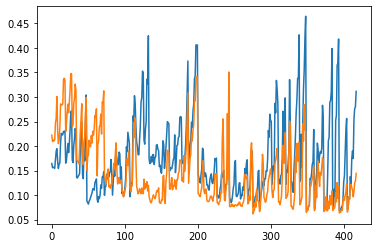

In [133]:
#plot atom-level results for ligand-lining residues

plt.plot(rmsf_apo_ligand)
plt.plot(rmsf_holo_ligand)


Text(0, 0.5, 'RMSF (nm)')

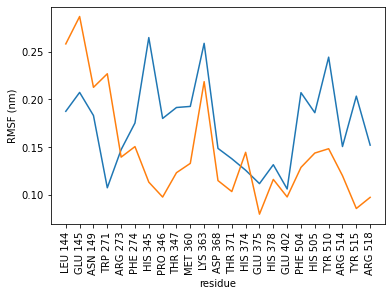

In [143]:
#plot residue-level results for ligand-lining residues

plt.plot(rmsf_apo_ligand_byres)
plt.plot(rmsf_holo_ligand_byres)

lining_inds_reformat = [i[0:3]+" "+i[3:] for i in lining_inds[5]]

plt.xticks(range(len(rmsf_apo_ligand_byres)), lining_inds_reformat, size='medium', rotation = 90)
plt.xlabel("residue")
plt.ylabel("RMSF (nm)")